### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# # Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations>=0.3.0 --user 
# !pip install -U --pre segmentation-models --user

In [2]:
!python --version

Python 3.6.7


In [3]:
!pip --version

pip 19.3.1 from /opt/conda/lib/python3.6/site-packages/pip (python 3.6)


In [4]:
# !pip list

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import shutil
import numpy as np
import matplotlib.pyplot as plt
import glob

from tqdm import tqdm

Using TensorFlow backend.


In [6]:
training = True

In [7]:
set_size = 1024
set_padding = 1280

In [8]:
x_train_dir = './data/resize_data/'
y_train_dir = './label/train_label/'

# x_val_dir = os.path.join(DATA_DIR, 'val/image')
# y_val_dir = os.path.join(DATA_DIR, 'val/label')


# x_test_dir = os.path.join(DATA_DIR, 'test/image')
# y_test_dir = os.path.join(DATA_DIR, 'test/label')

In [9]:
def remove_check_point(path):
    for file_name in os.listdir(path):
        #print(file_name)
        if 'checkpoints' in file_name:
            shutil.rmtree(os.path.join(path, file_name))
remove_check_point(x_train_dir)
remove_check_point(y_train_dir)

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [os.path.basename(x) for x in glob.glob(masks_dir+"/*.PNG")]
        # because masks files are smaller than images_dir
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        #oupput image name
        name = self.images_fps[i].split('/')[-1]

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


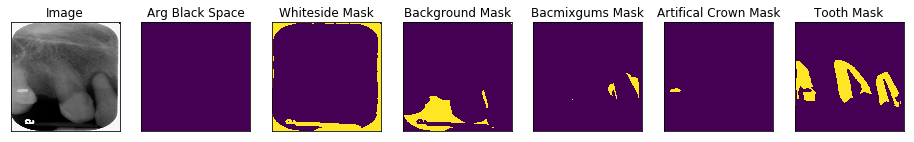

(1024, 1024, 3)


In [11]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes= ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'])
print(dataset.class_values)
image, mask = dataset[60] # get some sample

visualize(
    image=image, 
    arg_black_space=mask[..., 0].squeeze(),
    whiteside_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    bacmixgums_mask=mask[..., 3].squeeze(),
    artifical_crown_mask =mask[..., 4].squeeze(),
    tooth_mask =mask[..., 5].squeeze(),
#     overlap_mask=mask[..., 6].squeeze(),
#     cavity_mask =mask[..., 7].squeeze(),
#     cej_mask=mask[..., 8].squeeze(),
#     gums_mask =mask[..., 9].squeeze(),
#     img_depressed_mask=mask[..., 10].squeeze(),
)
print(image.shape)

In [12]:
# plt.figure(figsize=(12,12))
# plt.imshow(image)
# plt.show()

# #前牙 label
# #

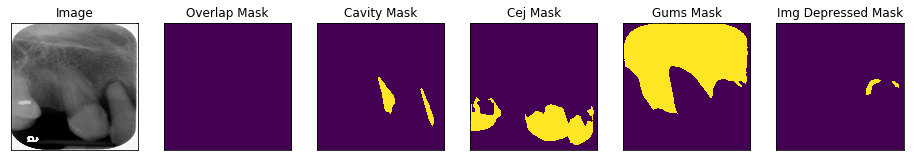

In [13]:
visualize(
    image=image, 
#     whiteside_mask=mask[..., 1].squeeze(),
#     background_mask=mask[..., 2].squeeze(),
#     bacmixgums_mask=mask[..., 3].squeeze(),
#     artifical_crown_mask =mask[..., 4].squeeze(),
#     tooth_mask =mask[..., 5].squeeze(),
    overlap_mask=mask[..., 6].squeeze(),
    cavity_mask =mask[..., 7].squeeze(),
    cej_mask=mask[..., 8].squeeze(),
    gums_mask =mask[..., 9].squeeze(),
    img_depressed_mask=mask[..., 10].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [14]:
import albumentations as A

In [15]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        #水平翻轉
        A.HorizontalFlip(p=0.5),
        #垂直翻轉
        A.VerticalFlip(p=0.5),
        #拉升 旋轉 位移
        A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=5, shift_limit=0.1, p=1, border_mode=0),
        
        #set_padding = 1280, set_size = 1024 
        #原圖1024*1024 將外部padding成 1280*1280
        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        #從1280*1280切割成1024
        A.RandomCrop(height=set_size, width=set_size, always_apply=True),
        
        #2成機率加入雜訊
        A.IAAAdditiveGaussianNoise(p=0.2),
        
        #套用clahe 隨機亮度調整
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
            ],
            p=0.5,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(set_padding, set_padding),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_training_enhance_augmentation():
    """Add paddings to make image shape divisible by 32"""
    fine_tune_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=90, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        )
    ]
    return A.Compose(fine_tune_transform)

def get_fine_tune_augmentation():
    """Add paddings to make image shape divisible by 32"""
    fine_tune_transform = [
        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        #A.HorizontalFlip(p=0.5),
#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=1,
#         ),
#         A.OneOf(
#             [
#                 A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1),
#             ],
#             p=1,
#         ),
#         A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=1, border_mode=0),
#         A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
#         A.RandomCrop(height=set_size, width=set_size, always_apply=True),
#         A.IAAAdditiveGaussianNoise(p=1),
#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=0.5,
#         )
    ]
    return A.Compose(fine_tune_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/opt/conda/lib/python3.6/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.6/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


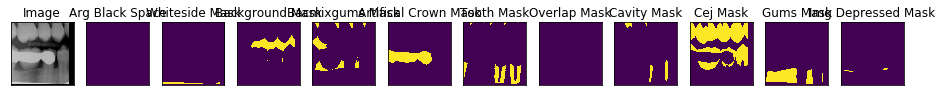

(1024, 1024, 3)
(1024, 1024, 11)


In [16]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes= ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'], augmentation=get_training_augmentation())
print(dataset.class_values)
image, mask = dataset[15] # get some sample

visualize(
    image=image, 
    arg_black_space=mask[..., 0].squeeze(),
    whiteside_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    bacmixgums_mask=mask[..., 3].squeeze(),
    artifical_crown_mask =mask[..., 4].squeeze(),
    tooth_mask =mask[..., 5].squeeze(),
    overlap_mask=mask[..., 6].squeeze(),
    cavity_mask =mask[..., 7].squeeze(),
    cej_mask=mask[..., 8].squeeze(),
    gums_mask =mask[..., 9].squeeze(),
    img_depressed_mask=mask[..., 10].squeeze(),
)

print(image.shape)
print(mask.shape)

In [17]:
# # Lets look at augmented data we have
# dataset = Dataset(x_train_dir, y_train_dir, classes=['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'], augmentation=get_fine_tune_augmentation())

# image, mask = dataset[1] # get some sample
# visualize(
#     image=image, 
#     arg_black_space=mask[..., 0].squeeze(),
#     whiteside_mask=mask[..., 1].squeeze(),
# #     background_mask=mask[..., 2].squeeze(),
# #     bacmixgums_mask=mask[..., 3].squeeze(),
# #     artifical_crown_mask =mask[..., 4].squeeze(),
# #     tooth_mask =mask[..., 5].squeeze(),
# #     overlap_mask=mask[..., 6].squeeze(),
# #     cavity_mask =mask[..., 7].squeeze(),
# #     cej_mask=mask[..., 8].squeeze(),
# #     gums_mask =mask[..., 9].squeeze(),
# #     img_depressed_mask=mask[..., 10].squeeze(),
# )
# print(image.shape)

In [18]:
# print(mask[..., 0].squeeze().shape)
# print(sum(sum(mask[..., 5].squeeze())))

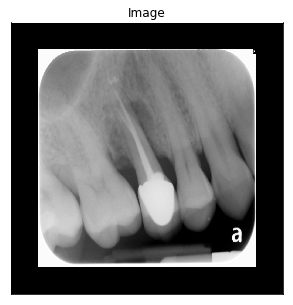

(1280, 1280, 3)


In [19]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'], augmentation=get_fine_tune_augmentation())

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
#     arg_black_space=mask[..., 0].squeeze(),
#     whiteside_mask=mask[..., 1].squeeze(),
#     background_mask=mask[..., 2].squeeze(),
#     bacmixgums_mask=mask[..., 3].squeeze(),
#     artifical_crown_mask =mask[..., 4].squeeze(),
#     tooth_mask =mask[..., 5].squeeze(),
#     overlap_mask=mask[..., 6].squeeze(),
#     cavity_mask =mask[..., 7].squeeze(),
#     cej_mask=mask[..., 8].squeeze(),
#     gums_mask =mask[..., 9].squeeze(),
#     img_depressed_mask=mask[..., 10].squeeze(),
)
print(image.shape)

# Segmentation model training

In [20]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [21]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2 #改成1
CLASSES = ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed']
#['background','bacmixgums', 'artifical_crown','tooth','gums','overlap','cavity','cej']
LR = 0.0001 
#defult LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [23]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 1, 1, 1.5, 1.5, 2, 4, 2, 2, 2, 3])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [24]:
# # model.summary()
# model.summary()

In [25]:
data_folder_name = '0801'

In [26]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

training_enhance_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_enhance_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
training_enhance_dataloader = Dataloder(training_enhance_dataset, batch_size=BATCH_SIZE, shuffle=True)

# #valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
# valid_dataset = Dataset(
#     x_val_dir, 
#     y_val_dir, 
#     classes=CLASSES, 
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
# )

# valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, set_size, set_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, set_size, set_size, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./weight/{}_train_ten_classes_20.h5'.format(data_folder_name), monitor="val_acc", save_weights_only=True, save_best_only=True, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(),
]

65


In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_20.h5'.format(data_folder_name))
    

Epoch 1/20
54/65 [=======================>......] - ETA: 20s - loss: 0.8573 - iou_score: 0.0843 - f1-score: 0.1109

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_40.h5'.format(data_folder_name))
    

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_60.h5'.format(data_folder_name))

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_80.h5'.format(data_folder_name))
    

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )
    model.save('./weight/{}_train_ten_classes_100.h5'.format(data_folder_name))
    

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_120.h5'.format(data_folder_name))
    

In [ ]:
if training:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=20, 
        callbacks=callbacks, 
#         validation_data=valid_dataloader, 
#         validation_steps=len(valid_dataloader),
    )

    model.save('./weight/{}_train_ten_classes_140.h5'.format(data_folder_name))
    

In [ ]:
assert 1<0 , 'stop'

In [ ]:
# load best weights
model.load_weights('./weight/{}_train_ten_classes_ford2_140.h5'.format(data_folder_name)) 

In [ ]:

# fine_tune_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     classes=CLASSES, 
#     augmentation=get_fine_tune_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
# )

# fine_tune_dataloader = Dataloder(fine_tune_dataset, batch_size=BATCH_SIZE, shuffle=True)

# # check shapes for errors
# assert fine_tune_dataloader[0][0].shape == (BATCH_SIZE, set_size, set_size, 3)
# assert fine_tune_dataloader[0][1].shape == (BATCH_SIZE, set_size, set_size, n_classes)

# # define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('../../weight/{}_ten_classes_fine_tune_ford2.h5'.format(data_folder_name), monitor="val_acc", save_weights_only=True, save_best_only=True, mode='max'),
#     keras.callbacks.ReduceLROnPlateau(),
# ]

In [ ]:
# if training:
#     # train model
#     history = model.fit_generator(
#         fine_tune_dataloader, 
#         steps_per_epoch=len(fine_tune_dataloader), 
#         epochs=20, 
#         callbacks=callbacks, 
#         #validation_data=valid_dataloader, 
#         #validation_steps=len(valid_dataloader),
#     )

#     model.save('../../weight/{}_ten_classes_fine_tune.h5'.format(data_folder_name))
    

In [ ]:
# if training:
#     # Plot training & validation iou_score values
#     plt.figure(figsize=(30, 5))
#     plt.subplot(121)
#     plt.plot(history.history['iou_score'])
#     #plt.plot(history.history['val_iou_score'])
#     plt.title('Model iou_score')
#     plt.ylabel('iou_score')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')

#     # Plot training & validation loss values
#     plt.subplot(122)
#     plt.plot(history.history['loss'])
#     #plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()